***Pattern recognition's project code***

The goal of this file is to create and test different method for binary classification of a graphomics dataset on Parkinson Disease (PD). The two class are (PD) and (Prodromal), an early stage of Parkinson.

The procedure follows these points:
- Data cleaning: removing bad generated net (num connected components > 1)
- Data visualization: plotting the variuos features histograms in order to identify problematic ones
- PCA: print the 3 main components of the data, in order to see if they are able to distinguish the two groups
- Random forest importance: use a random forest to estimate the crucial variables involved in distinguishing the two classes
- classification methods performance testing: here I tried (DT, KNN, RF, MLP), evaulating them following (Accuracy, Precision, Recall, F1)

In [78]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, matthews_corrcoef, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier


#df_r = pd.read_csv('PR-graphomics/reduced_graphomics.csv')
#Load the dataset in which the dictionaries contained in the original one are divided in different columns
df_f = pd.read_csv('PR-graphomics/expanded_graphomics.csv')
keys = df_f.keys()
df_f.pop('Unnamed: 0') #Removing the index feature that was causing biased performances




#removing the corrupted data, that is if the number of connected components is greater than one:

df = df_f[df_f['NumberOfConnectedComponents'] == 1]
df.pop('NumberOfConnectedComponents')
df.pop('NodeDegreeCentrality_node_degree_median')
print('New number of samples vs old number',len(df), len(df_f))

#divide the dataset into PD and control

Parkinsons = df[df['Group'] == 'PD']
Healthy = df[df['Group'] != 'PD']

print('New number of Parkinson vs Prodromal:',len(Parkinsons), len(Healthy))


targets = df.pop('Group')
data = df




New number of samples vs old number 234 300
New number of Parkinson vs Prodromal: 115 119


In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# Replace 'your_data.csv' with the path to your dataset

# Separate numerical and categorical columns
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object', 'category']).columns




In [80]:

# Plot distributions for numerical features
plt.figure(figsize=(150, 100))
for i, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features) // 3 + 1, 3, i + 1)
    sns.histplot(Parkinsons[feature], kde=True, color='red')
    sns.histplot(Healthy[feature], kde=True, color='blue')
    plt.xticks()
    plt.yticks()
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


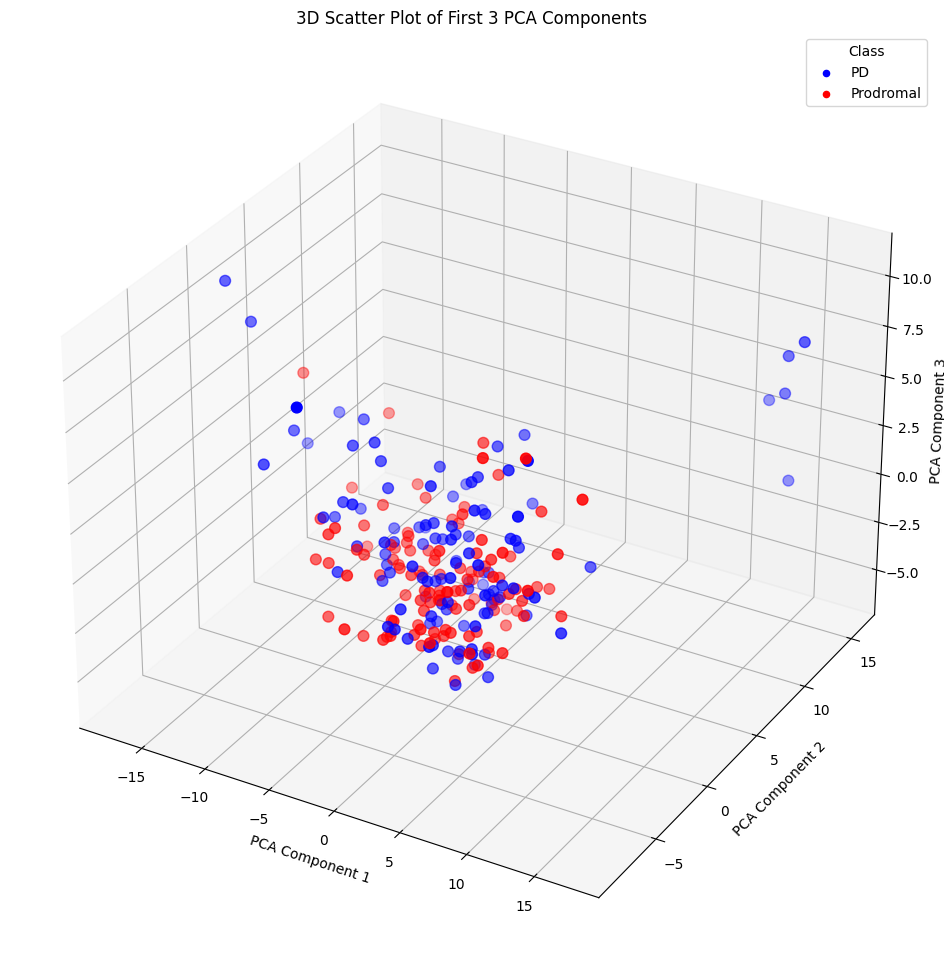

In [81]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = data 
y = targets # Target column containing 'PD' and 'Prodromal'

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Map target variable to colors
color_mapping = {'PD': 'blue', 'Prodromal': 'red'}
colors = y.map(color_mapping)

# Plot the first three PCA components
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=colors, s=60)

# Label axes
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title("3D Scatter Plot of First 3 PCA Components")

# Add legend manually
for label, color in color_mapping.items():
    ax.scatter([], [], [], color=color, label=label)
ax.legend(title="Class")

plt.show()

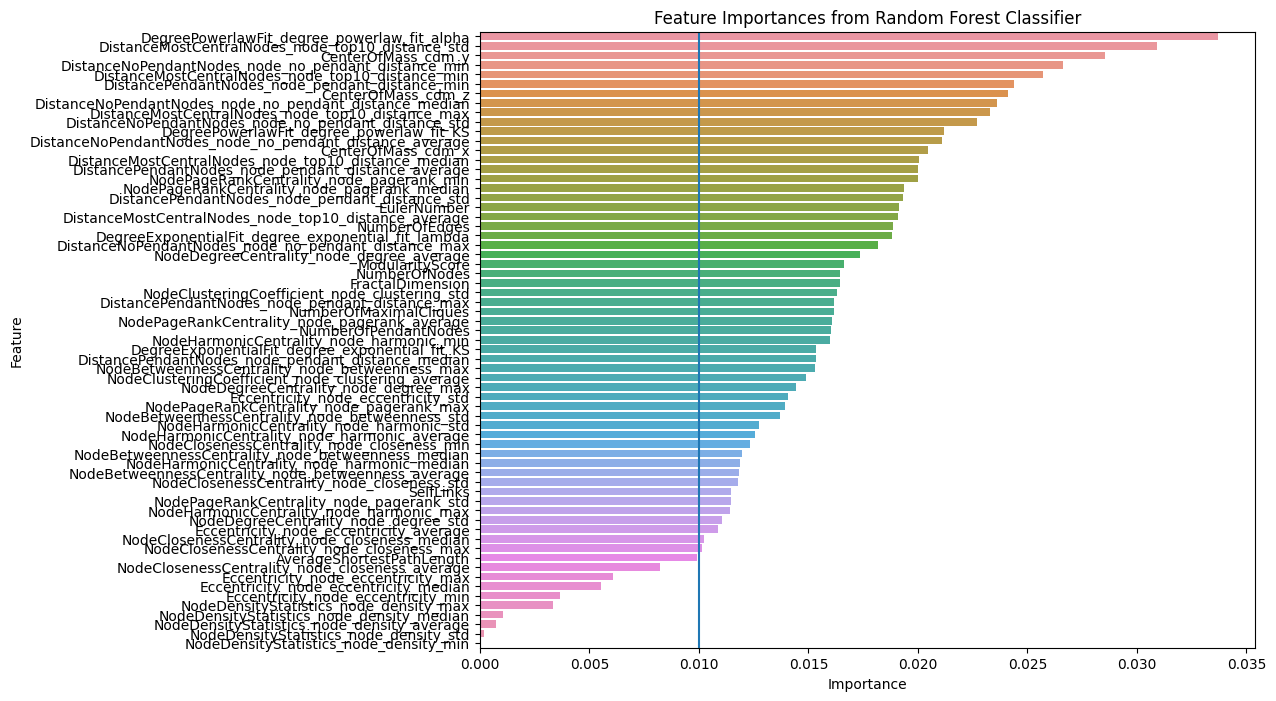

In [82]:
#Here I use a random forest classifier in order to estimate the importance of the different features in binary classification between PD and Prodromal

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 'PD' and 'Prodromal' get encoded as 0 and 1, for example

# Initialize and fit the Random Forest Classifier
forest = RandomForestClassifier(n_estimators=1000)
forest.fit(X, y_encoded)

# Get feature importances
feature_importances = forest.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importances from Random Forest Classifier")
plt.axvline(0.01, 0, 1000)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

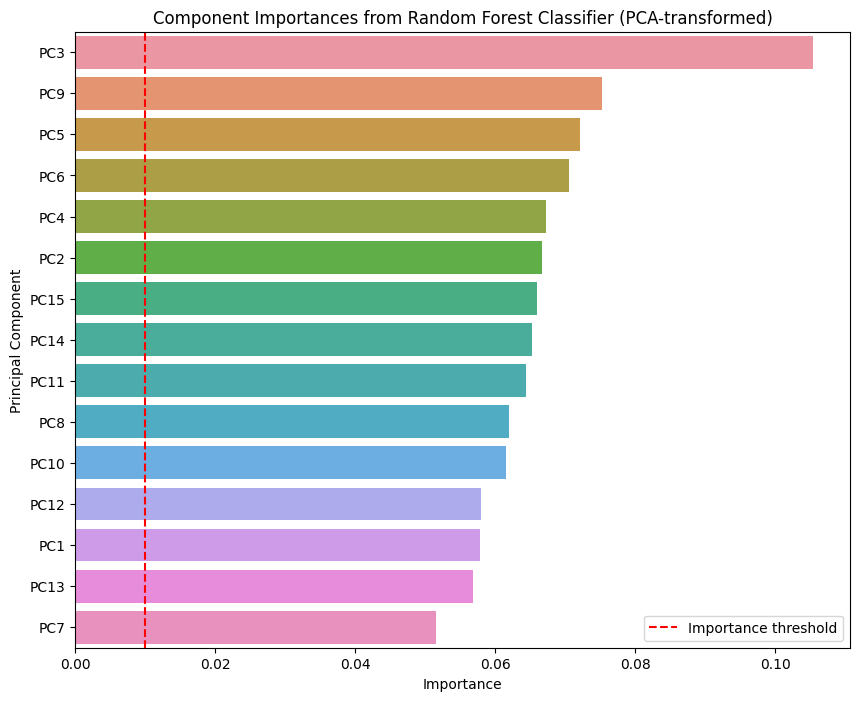

In [83]:

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=0)
X_pca = pca.fit_transform(X_scaled)

# Initialize and fit the Random Forest Classifier on PCA-transformed data
forest = RandomForestClassifier(n_estimators=1000, random_state=0)
forest.fit(X_pca, y_encoded)

# Get feature importances for the principal components
feature_importances = forest.feature_importances_

# Create a DataFrame for visualization
components = [f'PC{i+1}' for i in range(X_pca.shape[1])]
importance_df = pd.DataFrame({'Component': components, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Component', data=importance_df)
plt.title("Component Importances from Random Forest Classifier (PCA-transformed)")
plt.axvline(0.01, color='red', linestyle='--', label='Importance threshold')
plt.xlabel("Importance")
plt.ylabel("Principal Component")
plt.legend()
plt.show()

In [86]:
#Here I define the dataset, crossvalidation strategy and metrics for all of the model tested below.
# Separate features and target variable
X = data 
y = targets # Target column containing 'PD' and 'Prodromal'

# Encode target variable if it's categorical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 'PD' and 'Prodromal' get encoded as 0 and 1, for example

# Define the cross-validation strategy
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=100)


scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'matthews_corr': make_scorer(matthews_corrcoef),
    'b_accuracy': make_scorer(balanced_accuracy_score)
}

In [87]:


# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()


# Define scoring metrics

# Evaluate Decision Tree model
print("Evaluating Decision Tree Classifier...")
scores = {metric: cross_val_score(dt_classifier, X, y_encoded, scoring=scorer, cv=rkf) for metric, scorer in scoring.items()}

# Summarize results
dt_results = {metric: (np.mean(scores[metric]), np.std(scores[metric])) for metric in scores}
print("Decision Tree Results:")
for metric, (mean, std) in dt_results.items():
    print(f"{metric.capitalize()}: Mean={mean:.4f}, Std={std:.4f}")

Evaluating Decision Tree Classifier...
Decision Tree Results:
Accuracy: Mean=0.5486, Std=0.1005
Precision: Mean=0.5634, Std=0.1070
Recall: Mean=0.5597, Std=0.1514
F1: Mean=0.5500, Std=0.1121
Matthews_corr: Mean=0.0950, Std=0.2075
B_accuracy: Mean=0.5439, Std=0.1033


In [88]:

# Create the pipeline for KNN with Standard Scaling and PCA
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),  # Adjust the number of components as needed
    ('knn', KNeighborsClassifier(n_neighbors=5))  # n_neighbors can be tuned
])


# Evaluate KNN model with pipeline
print("Evaluating K-Nearest Neighbors Classifier with Standard Scaling and PCA...")
scores = {metric: cross_val_score(knn_pipeline, X, y_encoded, scoring=scorer, cv=rkf) for metric, scorer in scoring.items()}

# Summarize results
knn_results = {metric: (np.mean(scores[metric]), np.std(scores[metric])) for metric in scores}
print("KNN Results with Standard Scaling and PCA:")
for metric, (mean, std) in knn_results.items():
    print(f"{metric.capitalize()}: Mean={mean:.4f}, Std={std:.4f}")

Evaluating K-Nearest Neighbors Classifier with Standard Scaling and PCA...
KNN Results with Standard Scaling and PCA:
Accuracy: Mean=0.5292, Std=0.0934
Precision: Mean=0.5331, Std=0.0816
Recall: Mean=0.6490, Std=0.1355
F1: Mean=0.5799, Std=0.0923
Matthews_corr: Mean=0.0590, Std=0.2004
B_accuracy: Mean=0.5304, Std=0.0953


In [ ]:

# Create the pipeline for MLP with Standard Scaling
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500))  # Adjust hyperparameters as needed
])


# Evaluate MLP model with pipeline
print("Evaluating Multi-Layer Perceptron Classifier...")
scores = {metric: cross_val_score(mlp_pipeline, X, y_encoded, scoring=scorer, cv=rkf) for metric, scorer in scoring.items()}

# Summarize results
mlp_results = {metric: (np.mean(scores[metric]), np.std(scores[metric])) for metric in scores}
print("MLP Results with Standard Scaling:")
for metric, (mean, std) in mlp_results.items():
    print(f"{metric.capitalize()}: Mean={mean:.4f}, Std={std:.4f}")

Evaluating Multi-Layer Perceptron Classifier...
MLP Results with Standard Scaling:
Accuracy: Mean=0.5839, Std=0.0677
Precision: Mean=0.5916, Std=0.0681
Recall: Mean=0.5877, Std=0.1112
F1: Mean=0.5861, Std=0.0804


In [ ]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100)  # Adjust n_estimators if needed


# Evaluate Random Forest model
print("Evaluating Random Forest Classifier...")
scores = {metric: cross_val_score(rf_classifier, X, y_encoded, scoring=scorer, cv=rkf) for metric, scorer in scoring.items()}

# Summarize results
rf_results = {metric: (np.mean(scores[metric]), np.std(scores[metric])) for metric in scores}
print("Random Forest Results:")
for metric, (mean, std) in rf_results.items():
    print(f"{metric.capitalize()}: Mean={mean:.4f}, Std={std:.4f}")

Evaluating Random Forest Classifier...
Random Forest Results:
Accuracy: Mean=0.6003, Std=0.1385
Precision: Mean=0.6244, Std=0.1676
Recall: Mean=0.6038, Std=0.1997
F1: Mean=0.5961, Std=0.1572
